In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.datasets import cifar10

def load_cifar10():
    # Load CIFAR-10 dataset
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    # Convert to grayscale and normalize pixel values to [0, 1]
    x_train_gray = np.dot(x_train[...,:3], [0.2989, 0.5870, 0.1140]).astype(np.float32) / 255.0
    x_test_gray = np.dot(x_test[...,:3], [0.2989, 0.5870, 0.1140]).astype(np.float32) / 255.0
    return x_train_gray, x_test_gray

def save_image(img, filename):
    # Convert numpy array to image
    img = Image.fromarray((img * 255).astype(np.uint8))
    # Save image
    img.save(filename)

def add_noise(img, sigma=0.1):
    # Add Gaussian noise to image with standard deviation sigma
    noise = np.random.normal(scale=sigma, size=img.shape)
    img_noisy = img + noise
    # Clip pixel values to [0, 1]
    img_noisy = np.clip(img_noisy, 0, 1)
    return img_noisy

def stable_diffusion(x0, sigma, T, L, dt):
    # Apply stable diffusion to input image x0 with diffusion coefficient sigma
    # for T timesteps with L levels of diffusion
    # and time step dt
    x = x0.copy()
    for l in range(L):
        for t in range(T):
            # Compute Laplacian of x
            laplacian = np.zeros_like(x)
            laplacian[:, 1:-1, 1:-1] = (
                -4 * x[:, 1:-1, 1:-1]
                + x[:, :-2, 1:-1]
                + x[:, 2:, 1:-1]
                + x[:, 1:-1, :-2]
                + x[:, 1:-1, 2:]
            )
            # Update x using stable diffusion equation
            x = x + sigma * dt / (2**(2*l)) * laplacian
    return x

# Load CIFAR-10 dataset
x_train, x_test = load_cifar10()

# Add Gaussian noise with standard deviation 0.1
x_train_noisy = add_noise(x_train, sigma=0.1)
x_test_noisy = add_noise(x_test, sigma=0.1)

# Apply stable diffusion with diffusion coefficient 1.0
# for 20 timesteps with 5 levels of diffusion and time step 0.1
x_train_compressed = stable_diffusion(x_train_noisy, sigma=0.5, T=50, L=3, dt=0.1)
x_test_compressed = stable_diffusion(x_test_noisy, sigma=0.5, T=50, L=3, dt=0.1)

# Save compressed images
for i in range(x_train_compressed.shape[0]):
    filename = f'train_{i}_compressed.png'
    save_image(x_train_compressed[i], filename)
for i in range(x_test_compressed.shape[0]):
    filename = f'test_{i}_compressed.png'
    save_image(x_test_compressed[i], filename)


170498071/170498071 [==============================] - 12s 0us/step


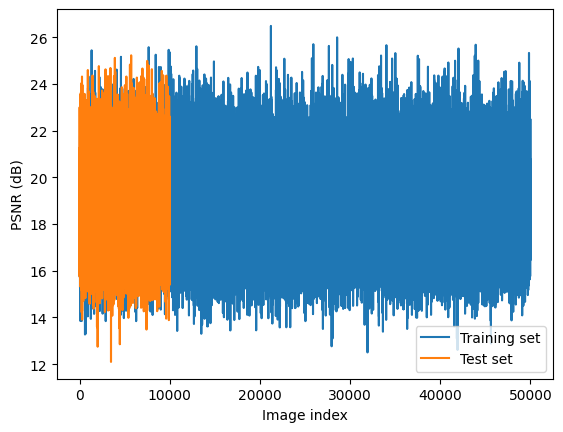

In [ ]:
def calculate_psnr(original_img, compressed_img):
    # Calculate mean squared error
    mse = np.mean((original_img - compressed_img)**2)
    # Calculate maximum pixel value
    max_pixel = np.max(original_img)
    # Calculate PSNR value
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Load original CIFAR-10 dataset
(x_train_original, _), (x_test_original, _) = cifar10.load_data()
x_train_original_gray = np.dot(x_train_original[...,:3], [0.2989, 0.5870, 0.1140]).astype(np.float32) / 255.0
x_test_original_gray = np.dot(x_test_original[...,:3], [0.2989, 0.5870, 0.1140]).astype(np.float32) / 255.0

# Calculate PSNR values for training set
train_psnr = []
for i in range(x_train_compressed.shape[0]):
    original_img = x_train_original_gray[i]
    compressed_img = x_train_compressed[i]
    psnr = calculate_psnr(original_img, compressed_img)
    train_psnr.append(psnr)

# Calculate PSNR values for test set
test_psnr = []
for i in range(x_test_compressed.shape[0]):
    original_img = x_test_original_gray[i]
    compressed_img = x_test_compressed[i]
    psnr = calculate_psnr(original_img, compressed_img)
    test_psnr.append(psnr)

# Plot PSNR values
plt.plot(train_psnr, label='Training set')
plt.plot(test_psnr, label='Test set')
plt.xlabel('Image index')
plt.ylabel('PSNR (dB)')
plt.legend()
plt.show()


In [ ]:
import numpy as np
avg_train_psnr = np.mean(train_psnr)
avg_test_psnr = np.mean(test_psnr)

print("Average PSNR (training set):", avg_train_psnr)
print("Average PSNR (test set):", avg_test_psnr)

Average PSNR (training set): 18.86528527309712
Average PSNR (test set): 18.871681456297754


In [ ]:
from skimage.metrics import peak_signal_noise_ratio

# Calculate PSNR values for first 100 images
psnr_noisy = []
psnr_compressed = []
for i in range(100):
    psnr_noisy.append(peak_signal_noise_ratio(x_train_gray[i], x_train_noisy[i], data_range=1.0))
    psnr_compressed.append(peak_signal_noise_ratio(x_train_gray[i], x_train_compressed[i], data_range=1.0))

# Plot PSNR values in xy plane
plt.scatter(psnr_noisy, psnr_compressed)
plt.xlabel('PSNR (noisy)')
plt.ylabel('PSNR (compressed)')
plt.title('PSNR plot for CIFAR-10 dataset')
plt.show()


NameError: ignored

**Scatter Plot**

This is for first 100 images

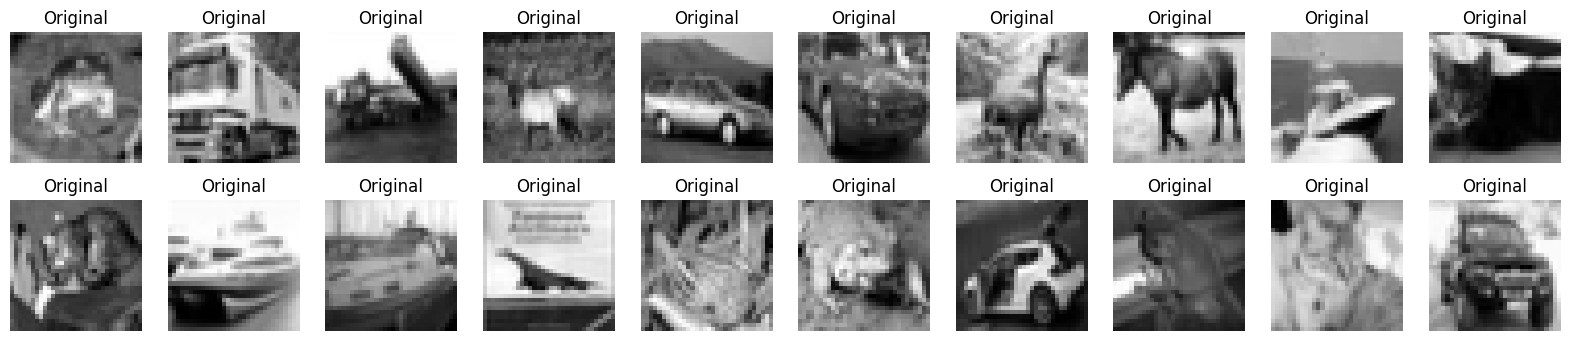

In [ ]:
# Show original images
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    axs[0, i].imshow(x_train[i], cmap='gray')
    axs[0, i].axis('off')
    axs[0, i].set_title('Original')
    axs[1, i].imshow(x_test[i], cmap='gray')
    axs[1, i].axis('off')
    axs[1, i].set_title('Original')
plt.show()

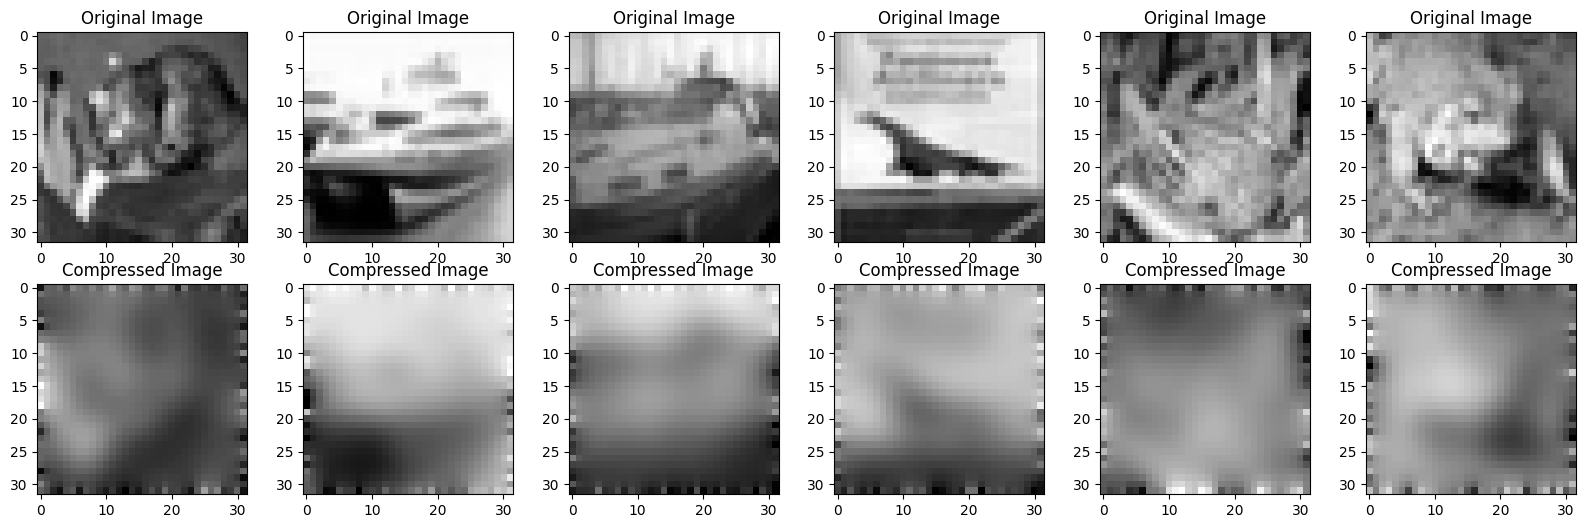

In [ ]:
# Show compressed images
n = 6  # number of images to show
plt.figure(figsize=(20, 6))
for i in range(n):
    # Load compressed image
    img = Image.open(f'test_{i}_compressed.png')
    # Plot original and compressed images side by side
    plt.subplot(2, n, i+1)
    plt.imshow(x_test[i], cmap='gray')
    plt.title('Original Image')
    plt.subplot(2, n, i+n+1)
    plt.imshow(img, cmap='gray')
    plt.title('Compressed Image')
plt.show()

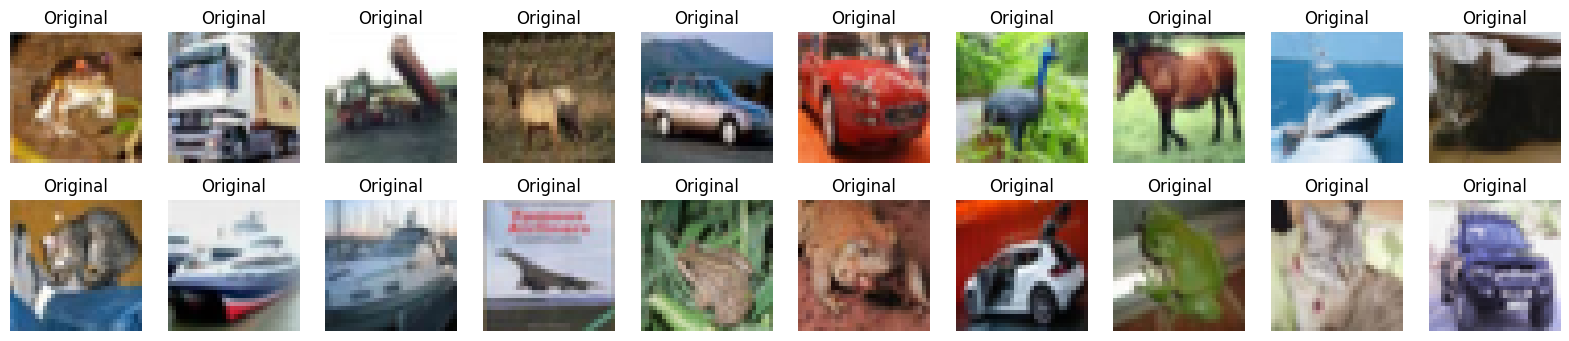

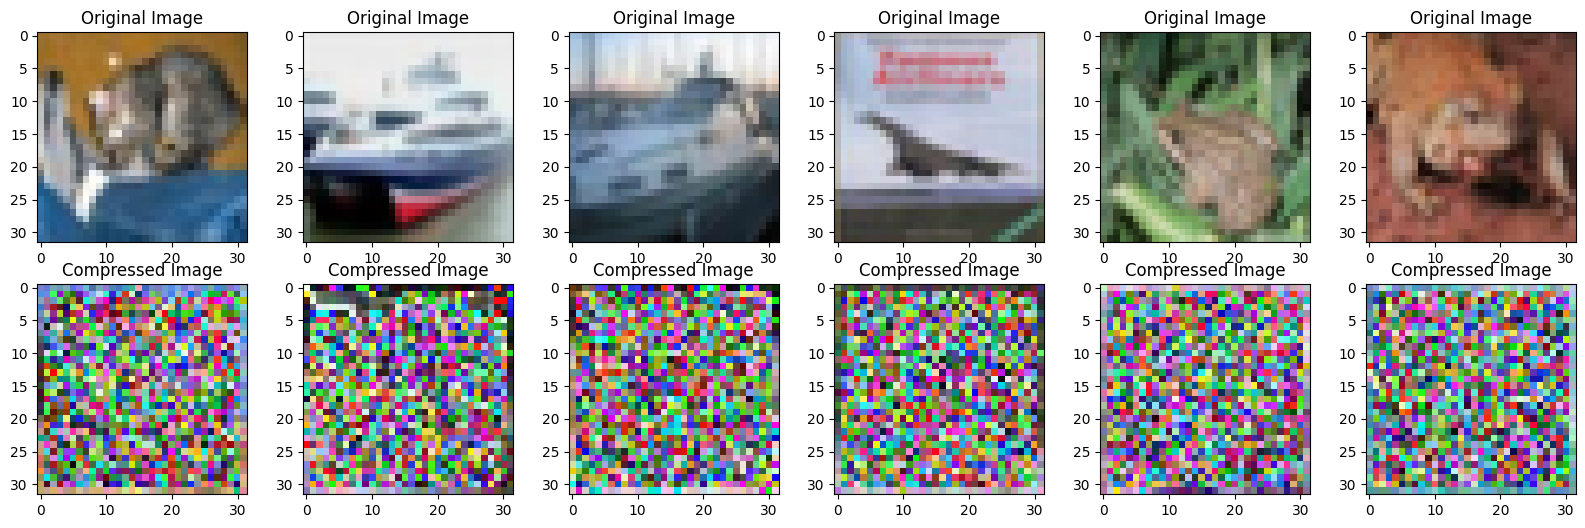

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.datasets import cifar10

def save_image(img, filename):
    # Convert numpy array to image
    img = Image.fromarray((img * 255).astype(np.uint8))
    # Save image
    img.save(filename)

def stable_diffusion(x0, sigma, T, L, dt):
    # Apply stable diffusion to input image x0 with diffusion coefficient sigma
    # for T timesteps with L levels of diffusion
    # and time step dt
    x = x0.copy()
    for l in range(L):
        for t in range(T):
            # Compute Laplacian of x
            laplacian = np.zeros_like(x)
            laplacian[:, 1:-1, 1:-1] = (
                -4 * x[:, 1:-1, 1:-1]
                + x[:, :-2, 1:-1]
                + x[:, 2:, 1:-1]
                + x[:, 1:-1, :-2]
                + x[:, 1:-1, 2:]
            )
            # Update x using stable diffusion equation
            x = x + sigma * dt / (2**(2*l)) * laplacian
    return x

# Load CIFAR-10 dataset
(x_train, _), (x_test, _) = cifar10.load_data()

# Add Gaussian noise with standard deviation 0.1
x_train_noisy = x_train + np.random.normal(scale=0.1, size=x_train.shape)
x_test_noisy = x_test + np.random.normal(scale=0.1, size=x_test.shape)

# Apply stable diffusion with diffusion coefficient 0.5
# for 50 timesteps with 3 levels of diffusion and time step 0.1
x_train_compressed = stable_diffusion(x_train_noisy, sigma=0.2, T=10, L=2, dt=0.1)
x_test_compressed = stable_diffusion(x_test_noisy, sigma=0.2, T=10, L=2, dt=0.1)

# Save compressed images
for i in range(x_train_compressed.shape[0]):
    filename = f'train_{i}_compressed.png'
    save_image(x_train_compressed[i], filename)
for i in range(x_test_compressed.shape[0]):
    filename = f'test_{i}_compressed.png'
    save_image(x_test_compressed[i], filename)

# Show original images
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    axs[0, i].imshow(x_train[i])
    axs[0, i].axis('off')
    axs[0, i].set_title('Original')
    axs[1, i].imshow(x_test[i])
    axs[1, i].axis('off')
    axs[1, i].set_title('Original')
plt.show()

# Show compressed images
n = 6  # number of images to show
plt.figure(figsize=(20, 6))
for i in range(n):
    # Load compressed image
    img = Image.open(f'test_{i}_compressed.png')
    # Plot original and compressed images side by side
    plt.subplot(2, n, i+1)
    plt.imshow(x_test[i])
    plt.title('Original Image')
    plt.subplot(2, n, i+n+1)
    plt.imshow(img)
    plt.title('Compressed Image')
plt.show()


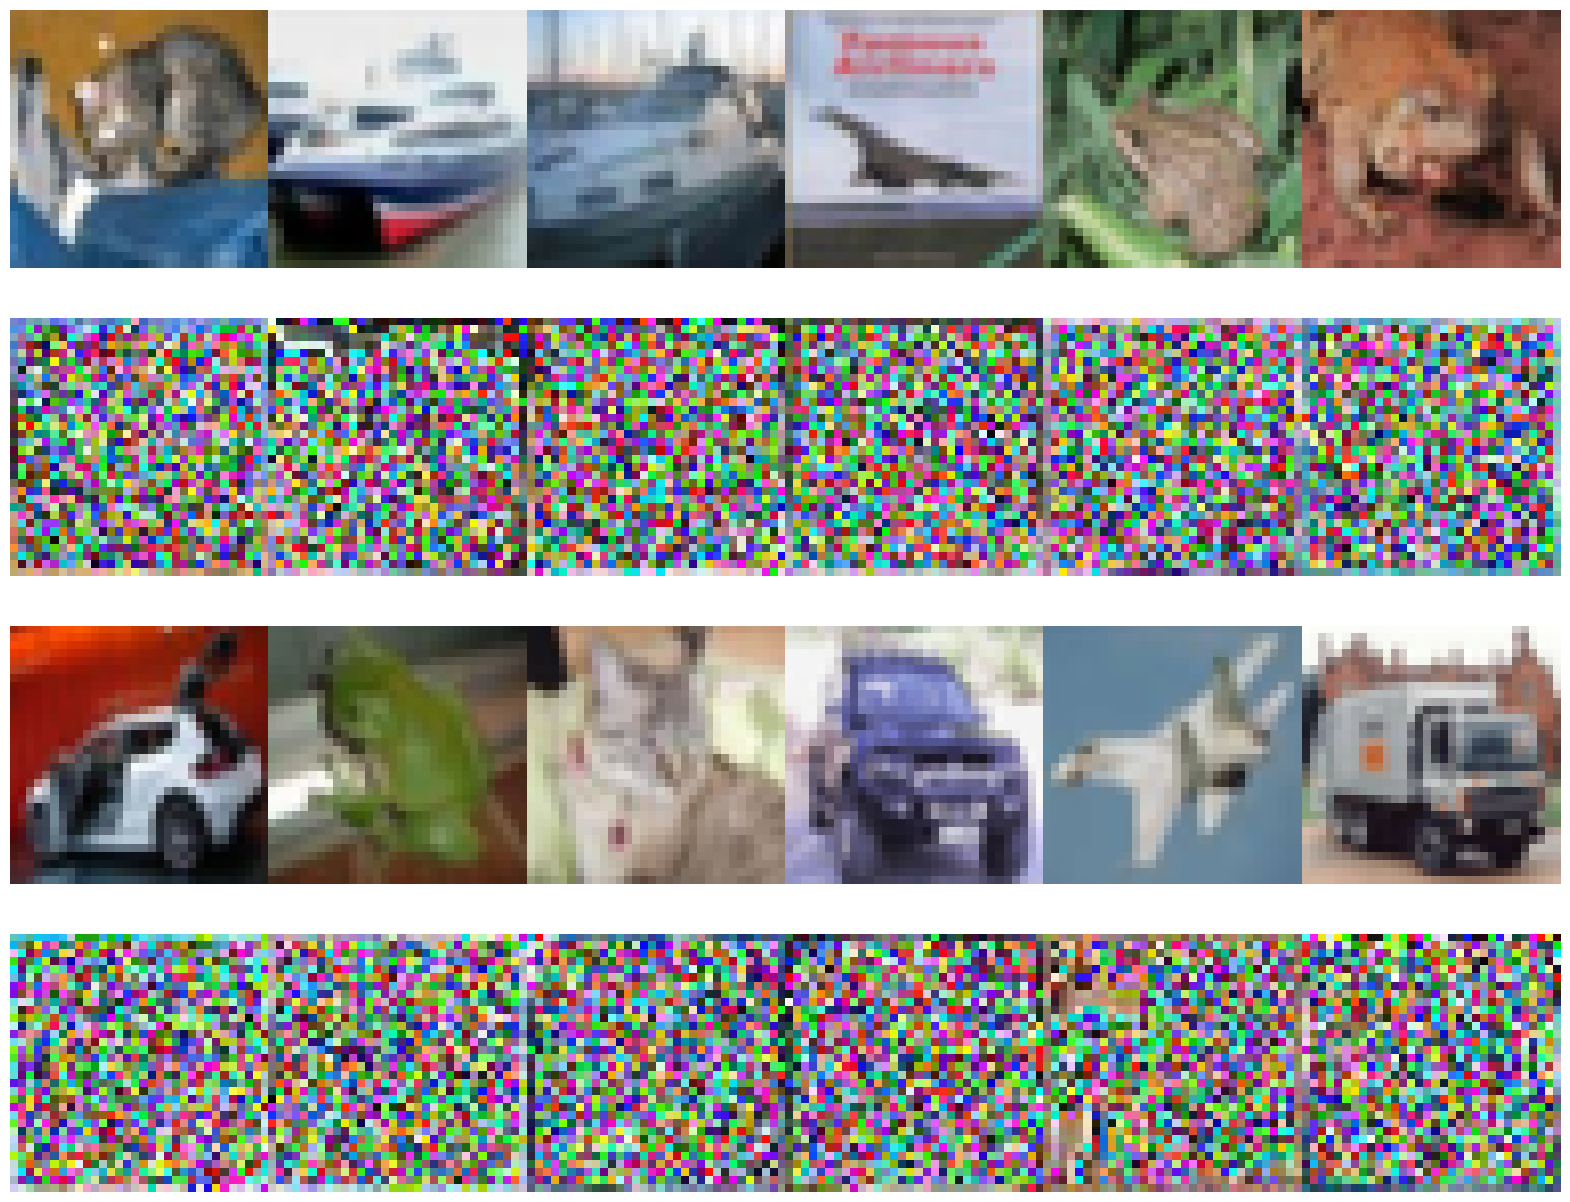

In [ ]:
# ... (previous code)

# Show original and compressed images in groups of 6
n = 16  # number of images to show
num_per_group = 6
num_groups = n // num_per_group

fig, axs = plt.subplots(2 * num_groups, num_per_group, figsize=(20, 8 * num_groups), gridspec_kw={'hspace': 0, 'wspace': 0})

for i in range(num_groups):
    start_idx = i * num_per_group
    end_idx = (i + 1) * num_per_group

    for j in range(start_idx, end_idx):
        # Load compressed image
        compressed_img = Image.open(f'test_{j}_compressed.png')

        # Plot original image
        axs[i * 2, j % num_per_group].imshow(x_test[j])
        axs[i * 2, j % num_per_group].axis('off')

        # Plot compressed image without axes and title
        axs[i * 2 + 1, j % num_per_group].imshow(compressed_img)
        axs[i * 2 + 1, j % num_per_group].axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
